# Extracting pseudo-lightcurve
## from SDO/HMI continuum intensity images

The SDO/HMI continuum images for the time of the 2012 transit of Venus were extracted from the JSOC archive (http://jsco.stanford.edu/), all 45s cadence continuum images from 4th June to the end of 7th June 2012 were downloaded.

Import all the dependeces needed to extract a pseudo-lightcurve from the images

In [1]:
%pylab inline

import warnings
warnings.filterwarnings("ignore") # to remove some warnings about bad fits headers

import glob
import numpy as np
import matplotlib.pylab as plt
import seaborn as sb
import pandas as pd

from astropy.utils.console import ProgressBar
from astropy.stats import LombScargle
from astropy.io import fits
from astropy.time import Time

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF, WhiteKernel

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Find all the HMI intensity files
listed = glob.glob('../sdo_raw_data/solar_venus_data/*.fits')
print('number of files:',len(listed))

number of files: 7673


In [3]:
# Loop through each of the images, and extract useful 
# observational metadata, as well as sum all pixels that 
# have positive values for each image. 

intensities = []
times = []
rsun_obs = []
with ProgressBar(len(listed),ipython_widget=True) as bar:
    for file in listed:
        with fits.open(file) as f:
            f.verify('fix')
            times.append(f[1]._header['DATE-OBS'])
            rsun_obs.append(f[1].header['RSUN_OBS'])
            _data = np.array(f[1].data)
            _data = np.nan_to_num(_data)
            _data[_data<0] = 0
            intensities.append(np.nansum(_data))
            

        bar.update()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [4]:
# Convert time to JD
t = Time(times, format='isot', scale='utc')
times = t.jd

Since the SDO spacecraft is in orbit, the apparent size of the sun on the CCD varies from image to image. This means that the summed intensities are dependent on the number of illuminated pixels in that image, however we can correct for that effect, knowing the apparent size of the sun. 

The intensity values for each image are therefore scaled with the square of the apparent solar radius for each image, and then median normalised.

In [5]:
ys2 = np.array(intensities)/np.square(np.array(rsun_obs))
ys2 = ys2/np.median(ys2)

In [6]:
# Importing data from existing collation of intensity 
# values from images (to save time)

_data = pd.read_csv('./venus_data.csv')
times = np.array(_data['times'])
ys2 = np.array(_data['raw_flux'])

Plot of initial lightcurve of intensity values with time.

The transit can clearly be seen around JD=2456084.5, however there is a large and significant pseudo-periodic signal also very apparent in the plot.

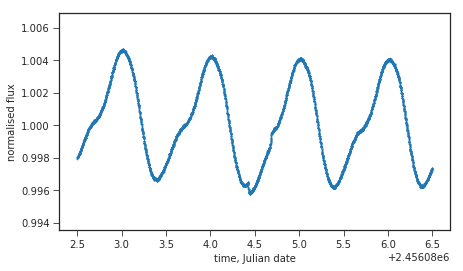

In [7]:
with sb.axes_style('ticks'):
    fig, axs = plt.subplots(1,1, figsize=(7,4))
    axs.scatter(times, ys2,s=0.5)
    plt.setp(axs,xlabel='time, Julian date',ylabel='normalised flux')
    #fig.savefig('venus_nonorm.png')

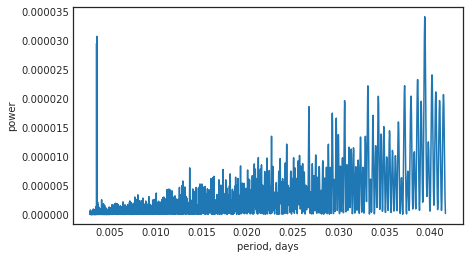

In [8]:
frequency, power = LombScargle(times,ys2).autopower(minimum_frequency=24.,
                                                    maximum_frequency=350,
                                                    samples_per_peak=10)

with sb.axes_style('white'):
    fig, axs = plt.subplots(1,1, figsize=(7,4))
    axs.plot(1/frequency, power)
    plt.setp(axs,xlabel='period, days',ylabel='power')
    #plt.setp(axs,xlim=[0.003,0.005])

In [9]:
#noise = np.random.normal(0,0.00005,ys2.shape)
noise = 0.

ys2 = ys2 + noise
yerr = np.ones_like(ys2)*0.0001

X = np.atleast_2d(np.hstack((times[times<2456084.42],times[times>2456084.69]))).T
#X = np.atleast_2d(times).T
Y = np.hstack((ys2[times<2456084.42],ys2[times>2456084.69]))
#Y = np.atleast_2d(ys2).T
YERR = np.hstack((yerr[times<2456084.42],yerr[times>2456084.69]))
#YERR = np.atleast_2d(yerr).T

fac = 1
X = X[::fac,:]
Y = Y[::fac]
YERR = YERR[::fac]

In [10]:
period = 1436.14/(60.*24.)

#k1 = 0.0001 * WhiteKernel(noise_level=1e-5)
k2 = 0.01 * RBF(length_scale=5.0) * ExpSineSquared(length_scale=0.5, periodicity=period, periodicity_bounds=(period-0.001,period+0.001))
#k2 = 0.01 * ExpSineSquared(length_scale=0.25, periodicity=period, periodicity_bounds=(period-0.01,period+0.01))
k3 = 0.01 * RBF(length_scale=5.0)
#kernel = k1 + k2 + k3
kernel = k2 
old_k2 = 0.01 * RBF(length_scale=5.0) * ExpSineSquared(length_scale=0.5, periodicity=period, periodicity_bounds=(period-0.001,period+0.001))

gp = GaussianProcessRegressor(kernel=kernel,alpha=YERR**2.,normalize_y=True)
gp.fit(X,Y)

print("Learned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))

Learned kernel: 0.0706**2 * RBF(length_scale=8.18) * ExpSineSquared(length_scale=1.92, periodicity=0.996)
Log-marginal-likelihood: 58521.479


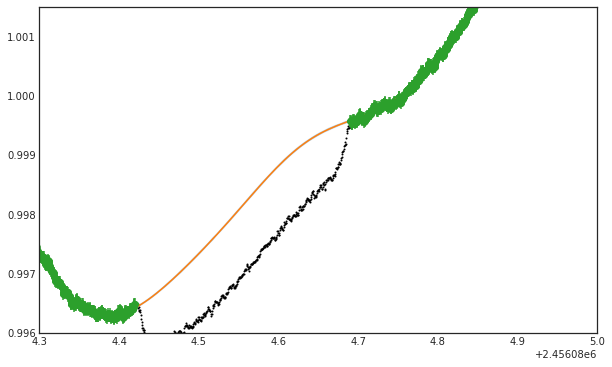

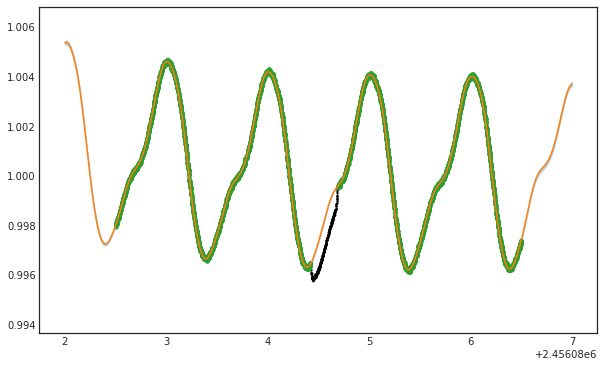

In [11]:
X_ = np.atleast_2d(np.linspace(X.min() - 0.5, X.max() + 0.5, 1000)).T
y_pred, y_std = gp.predict(X_, return_std=True)

cp = sb.color_palette()

with sb.axes_style('white'):
    fig,axs = plt.subplots(1,1,figsize=(10,6))
    axs.scatter(times,ys2,s=1,c='k')
    axs.errorbar(X,Y,yerr=YERR,c=cp[2],fmt='o')
    axs.scatter(X,Y,s=25,c=cp[2])
    axs.plot(X_,y_pred,c=cp[1])
    axs.fill_between(X_[:,0], (y_pred - y_std), (y_pred + y_std),alpha=0.25, color=cp[0])
    plt.setp(axs,xlim=[2456084.3,2456085.0],ylim=[0.996,1.0015])
    
with sb.axes_style('white'):
    fig,axs = plt.subplots(1,1,figsize=(10,6))
    axs.scatter(times,ys2,s=1,c='k')
    axs.scatter(X,Y,s=10,c=cp[2])
    axs.plot(X_,y_pred,c=cp[1])
    axs.fill_between(X_[:,0], (y_pred - y_std), (y_pred + y_std),alpha=0.25, color=cp[0])


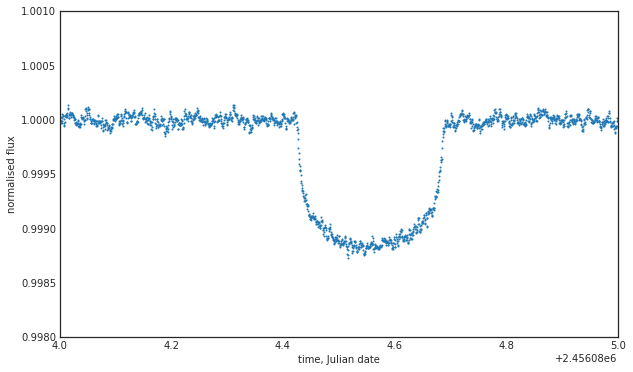

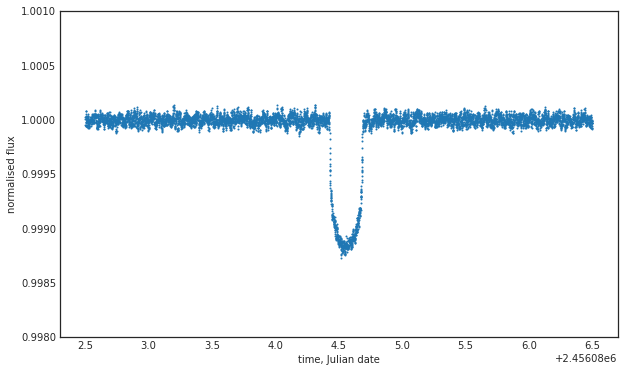

In [12]:
y_pred2, y_std2 = gp.predict(np.atleast_2d(times).T, return_std=True)

with sb.axes_style('white'):
    fig,axs = plt.subplots(1,1,figsize=(10,6))
    axs.scatter(times,ys2/y_pred2,s=1)
    plt.setp(axs,ylim=[0.998,1.001],xlim=[2456084,2456085])
    plt.setp(axs,xlabel='time, Julian date',ylabel='normalised flux')
    #fig.savefig('venus_transit_zoom.png')
    
with sb.axes_style('white'):
    fig,axs = plt.subplots(1,1,figsize=(10,6))
    axs.scatter(times,ys2/y_pred2,s=1)
    #axs.errorbar(times[::50],ys2[::50]/y_pred2[::50,0],yerr=y_std2[::50],fmt='o')
    plt.setp(axs,ylim=[0.998,1.001])
    plt.setp(axs,xlabel='time, Julian date',ylabel='normalised flux')
    #fig.savefig('venus_transit.png')

In [13]:
dat = pd.DataFrame(np.vstack((times,(ys2/y_pred2))).T,
                   columns=['times','flux'])
dat.to_csv('venus_data_scikit.csv',index=False)